In [26]:
import csv
import numpy as np
import pandas as pd
from pathlib import Path
from operator import itemgetter

# import plotly.graph_objects as go
# import plotly.io as pio
# from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

In [32]:
otype = ['rnd',
         'max_weight',
         'min_weight',
         'max_avg_value',
         'min_avg_value',
         'max_max_value',
         'min_max_value',
         'max_min_value',
         'min_min_value',
         'max_avg_value_by_weight',
         'max_max_value_by_weight']

otype_idx = {'rnd': 0,
         'max_weight': 1,
         'min_weight': 2,
         'max_avg_value': 3,
         'min_avg_value': 4,
         'max_max_value': 5,
         'min_max_value': 6,
         'max_min_value': 7,
         'min_min_value': 8,
         'max_avg_value_by_weight': 9,
         'max_max_value_by_weight': 10}


In [28]:
def parse_output(filepath):
    result = {}
    with open(filepath) as fp:
        outs = csv.reader(fp, delimiter=',')
        
        for out in outs:
            out = [o.strip() for o in out]
            prob, s, p, n, inst = out[0].split("/")[-1].split(".")[0].split('_')
            # prob, s, n, p, inst = out[0].split("/")[-1].split(".")[0].split('-')
            otype = out[1]
            iwd = int(out[2])
            rwd = int(out[3])
            isz = int(out[4])
            rsz = int(out[5])
            iac = int(out[6])
            rac = int(out[7])
            rszac = int(out[8])
            # rszac = rsz + rac
            ctime = float(out[9])
            rtime = float(out[10])
            ptime = float(out[11])
            ttime = float(out[12])
            modz = int(out[13])
            order = list(map(int, out[14].split("|")[:-1]))
            
            if prob not in result:
                result[prob] = {}
                
            if s not in result[prob]:
                result[prob][s] = {}

            if p not in result[prob][s]:
                result[prob][s][p] = {}
            
            if n not in result[prob][s][p]:
                result[prob][s][p][n] = {}
                                
            if inst not in result[prob][s][p][n]:
                result[prob][s][p][n][inst] = {}
                
            if otype not in result[prob][s][p][n][inst]:
                result[prob][s][p][n][inst][otype] = {
                    'iwd': iwd, 'rwd': rwd, 'isz': isz, 'rsz': rsz, 
                    'iac': iac, 'rac': rac, 'rszac': rszac,
                    'ctime': ctime, 'rtime': rtime, 'ptime': ptime, 'ttime': ttime,
                    'modz': modz, 'order': order   
                }
                                                    
    return result

In [29]:
def get_data(data, 
             prob='kp', seed='7', 
             n='20', p='3', 
             otype=['rnd', 'max_weight'], 
             project='rsz', nrnd=5):

    vals = []
    if n not in data[prob][seed][p]:
        return vals
        
    d = data[prob][seed][p][n]
    insts = list(d.keys())
    insts.sort()
    for i in insts:
        val = []
        for o in otype:
            if o == 'rnd':
                nruns = [1 if 'rnd'+str(j) in d[i] else 0 for j in range(nrnd)]
                if np.sum(nruns) == nrnd:
                    _val = [d[i][f'{o}{j}'][project] for j in range(nrnd)]
                    val.append(np.mean(_val))
                else:
                    val.append(None)
                    
                                            
            else:
                if o in d[i] and project in d[i][o]:
                    val.append(d[i][o][project])
                else:
                    val.append(None)
        
        vals.append(val)
        
    return vals

In [33]:
def get_data_xy(data,
                prob='kp', seed='7',
                n='20', p='3',
                otype='max_weight',
                x='rszac',
                y='ttime'):

    xvals, yvals = [], []
    if n not in data[prob][seed][p]:
        return xvals, yvals

    d = data[prob][seed][p][n]
    insts = list(d.keys())
    insts.sort()
    for i in insts:
        xval, yval = [], []
        if o in d[i] and x in d[i][o] and y in d[i][o]:
            xvals.append(d[i][o][x])
            yvals.append(d[i][o][y])
                
    return xvals, yvals


In [30]:
def plot_scatter(axes, x, y, alpha=0.5, s=15, xlabel='min_weight', ylabel='RND', c='', cmap=''):
    max_lim = np.max([x, y])
    max_lim *= 1.05
    min_lim = np.min([x, y])
    min_lim *= 0.95
    print("Limits ", min_lim, max_lim)
    
    axes.scatter(x, y, alpha=alpha, s=s)
    axes.plot([min_lim, max_lim], [min_lim, max_lim], 'k-', alpha=0.4, zorder=0)
    axes.set_xlim(min_lim, max_lim)
    axes.set_ylim(min_lim, max_lim)
    axes.set_aspect('equal')
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)

def plot_table(axes, cellText, proj):
    colLabels = ["Order type", f"Mean {proj} (RND/order)"]
    cellText = cellText
    axes.set_axis_off()
    table = axes.table(
        cellText=cellText,
        colLabels=colLabels,
        colColours=["palegreen"] * 10,
        cellLoc='center',
        loc='upper left')

In [31]:
obj_var_cfg = ['3_20', '3_40', '3_60', '3_80', '3_100', '5_20', '5_30', '5_40','7_20', '7_30', '7_40']
project = ['rsz', 'rac', 'rszac', 'ttime']
result = parse_output('out_final_edge.csv')

for proj in project:
    print("Projecting ", proj)
    for ovc in obj_var_cfg:
        p, n = ovc.split("_")
        print(f"Objectives: {p}, Variables {n}")
        vals = get_data(result, p=p, n=n, otype=otype, project=proj)
        ival = len(vals)
        if ival == 0:
            print('No instances solved...')
            continue
        vals = [v for v in vals if None not in v]
        print("Cleaned vals ", ival, len(vals))
        vals = np.asarray(vals)
        
        # Prepare order-project table data
        order_size_map = []
        for idx, o in enumerate(otype):
            if o == 'rnd':
                continue
            order_size_map.append((o, idx, np.mean(vals[:, 0] / vals[:, idx])))
        
        # Find the best order
        order_size_map = sorted(order_size_map, key=itemgetter(2), reverse=True)
        best_order = order_size_map[0][0]
        best_idx = order_size_map[0][1]
        print(f"Best order: {best_order}")
        
        # Convert table data to string
        order_size_map_str = []
        for osm in order_size_map:
            order_size_map_str.append([osm[0], f"{osm[2]:.3f}"])
        
        # Plot    
        fig, ax = plt.subplots(1, 2)
        plot_scatter(ax[0], vals[:, best_idx], vals[:, 0], xlabel=best_order)
        plot_table(ax[1], order_size_map_str, proj)        
        fig.suptitle(f'{p}_{n}_{proj}, inst:{len(vals)}')
        fig.set_size_inches(12, 6)
        fig.savefig(f'{p}_{n}_{proj}.pdf', dpi=100)
        plt.close()
        
        print(".................................")            
    print("++++++++++++++++++++++++++++++++")

Projecting  rsz
Objectives: 3, Variables 20
Cleaned vals  250 250
Best order: max_weight
Limits  1216.0 2549.1900000000005
.................................
Objectives: 3, Variables 40
Cleaned vals  250 250
Best order: max_weight
Limits  43468.2 133635.6
.................................
Objectives: 3, Variables 60
Cleaned vals  250 250
Best order: max_weight
Limits  159531.6 398949.39
.................................
Objectives: 3, Variables 80
Cleaned vals  49 32
Best order: max_weight
Limits  395404.25 760202.1
.................................
Objectives: 3, Variables 100
No instances solved...
Objectives: 5, Variables 20
Cleaned vals  250 250
Best order: max_weight
Limits  1136.2 2561.3700000000003
.................................
Objectives: 5, Variables 30
Cleaned vals  250 250
Best order: max_weight
Limits  15222.8 39276.72
.................................
Objectives: 5, Variables 40
Cleaned vals  250 250
Best order: max_weight
Limits  47426.85 123142.11
....................

In [36]:
from sklearn import linear_model


ModuleNotFoundError: No module named 'sklearn'

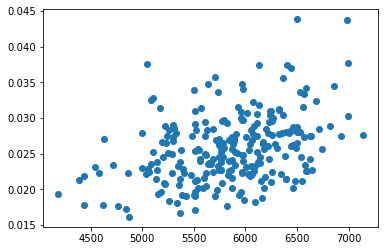

In [35]:
# obj_var_cfg = ['3_20', '3_40', '3_60', '3_80', '3_100', '5_20', '5_30', '5_40','7_20', '7_30', '7_40']
p = '3'
n = '20'
order = 'min_weight'
x = 'rszac'
y = 'ttime'


xvals, yvals = get_data_xy(result, p=p, n=n, otype=order, x=x, y=y)
if len(xvals) and len(yvals) and len(xvals) == len(yvals):    
    # reg = linear_model.LinearRegression()
    # reg.fit(xvals, yvals)
    # print(reg.coef_, reg.intercept_)
    
    # xline = np.linspace(np.min(xvals), np.max(xvals), 100)
    # yline = ref.coef_*x + reg.intercept_
    
    plt.scatter(xvals, yvals)
    # plt.plot(xline, yline)
    plt.show()
    plt.close()


# result = parse_output('out_final_edge.csv')

# for proj in project:
#     print("Projecting ", proj)
#     for ovc in obj_var_cfg:
#         p, n = ovc.split("_")
#         print(f"Objectives: {p}, Variables {n}")
#         vals = get_data(result, p=p, n=n, otype=otype, project=proj)
#         ival = len(vals)
#         if ival == 0:
#             print('No instances solved...')
#             continue
#         vals = [v for v in vals if None not in v]
#         print("Cleaned vals ", ival, len(vals))
#         vals = np.asarray(vals)
        
#         # Prepare order-project table data
#         order_size_map = []
#         for idx, o in enumerate(otype):
#             if o == 'rnd':
#                 continue
#             order_size_map.append((o, idx, np.mean(vals[:, 0] / vals[:, idx])))
        
#         # Find the best order
#         order_size_map = sorted(order_size_map, key=itemgetter(2), reverse=True)
#         best_order = order_size_map[0][0]
#         best_idx = order_size_map[0][1]
#         print(f"Best order: {best_order}")
        
#         # Convert table data to string
#         order_size_map_str = []
#         for osm in order_size_map:
#             order_size_map_str.append([osm[0], f"{osm[2]:.3f}"])
        
#         # Plot    
#         fig, ax = plt.subplots(1, 2)
#         plot_scatter(ax[0], vals[:, best_idx], vals[:, 0], xlabel=best_order)
#         plot_table(ax[1], order_size_map_str, proj)        
#         fig.suptitle(f'{p}_{n}_{proj}, inst:{len(vals)}')
#         fig.set_size_inches(12, 6)
#         fig.savefig(f'{p}_{n}_{proj}.pdf', dpi=100)
#         plt.close()
        
#         print(".................................")            
#     print("++++++++++++++++++++++++++++++++")

In [23]:
import pandas as pd

df = pd.read_csv('out_final_edge.csv')


In [25]:
df['ctime']

0        0.035552
1        0.018669
2        0.017795
3        0.016596
4        0.016781
           ...   
34258    0.161185
34259    0.103390
34260    0.117971
34261    0.102761
34262    0.138518
Name: ctime, Length: 34263, dtype: float64

In [29]:
def make_scatter(row=1, col=2, name=[["iwd", "rwd"]],
                 figxtitle='max_weight', 
                 figytitle='rnd5',
                 xval=[[[1, 2, 3], [20, 30, 40]]], 
                 yval=[[[2, 3, 4], [5, 5, 5]]],
                 height=500, width=700, shared_yaxes=False, shared_xaxes=False):


    # subxtitle = [[None, None]],
    # subytitle = [[None, None]],


    fig = make_subplots(rows=row, cols=col, 
                        shared_yaxes=shared_yaxes, 
                        shared_xaxes=shared_xaxes,
                        x_title=figxtitle, 
                        y_title=figytitle)
    
    for r in range(row):
        for c in range(col):
            fig.add_trace(go.Scatter(x=xval[r][c], y=yval[r][c], mode="markers", name=name[r][c]), 
                          row=r+1, col=c+1)
            # fig.update_xaxes(title_text=subxtitle[r][c], row=r+1, col=c+1)
            # fig.update_yaxes(title_text=subytitle[r][c], row=r+1, col=c+1)

    
    fig.update_layout(height=height, width=width, title_text="")
    
    return fig

In [13]:
np.asarray([1, 1, 1])/np.asarray([2, 2, 2])

array([0.5, 0.5, 0.5])

In [41]:
for i in order_size_map:
    print(i)

('max_weight', 1.2315755409149018)
('min_weight', 1.2315755409149018)
('max_avg_value', 1.0023280288712533)
('min_avg_value', 1.002470506931012)
('max_max_value', 0.9990156012500656)
('min_max_value', 0.9992607084353976)
('max_min_value', 1.0014023658342122)
('min_min_value', 1.0013091899671218)
('max_avg_value_by_weight', 1.1497597354918605)
('max_max_value_by_weight', 1.1718485705849164)


In [48]:
xs = ['max_weight',
'min_weight',
'max_avg_value',
'min_avg_value',
'max_max_value',
'min_max_value',
'max_min_value',
'min_min_value',
'max_avg_value_by_weight',
'max_max_value_by_weight']

def loop_make_scatter(prob='kp', n='20', p='3', seed='7', qty=['iwd', 'rwd']):
    xdata, ydata = [], []
    for x in xs:
        for q in qty:
            _x, _y = get_scatter_data(result, prob=prob, seed=seed,
                                    n=n, p=p, x=x, qty=q)
            xdata.append(_x)
            ydata.append(_y)
            
        # fig = make_scatter(col=len(qty),
        #             name=[qty], 
        #             figxtitle=x,
        #             xval=[xdata],
        #             yval=[ydata])
        
        
        print(xdata[1])
        
        # qty_str = "_".join(qty)
        # logpath = Path(
        #     f'./{prob}/{seed}/{p}_{n}/{qty_str}')
        # Path.mkdir(logpath, parents=True, exist_ok=True)
        # figpath = logpath / f'{x}.jpg'
        
        # pio.write_image(fig, figpath, format='jpg')
              
loop_make_scatter()

[346, 381, 345, 378, 304, 345, 306, 356, 373, 280, 318, 336, 358, 403, 342, 398, 379, 274, 341, 375, 402, 392, 325, 448, 357, 329, 275, 336, 348, 374, 348, 369, 404, 342, 304, 328, 341, 434, 317, 373, 274, 373, 299, 335, 396, 322, 339, 375, 321, 359, 380, 388, 373, 316, 279, 362, 377, 375, 353, 313, 307, 298, 448, 366, 358, 391, 416, 361, 254, 243, 431, 385, 319, 427, 310, 367, 345, 478, 376, 283, 381, 386, 324, 319, 382, 289, 364, 339, 367, 306, 382, 285, 360, 317, 317, 232, 423, 306, 319, 298, 397, 310, 367, 455, 438, 267, 392, 257, 389, 409, 382, 397, 367, 387, 374, 320, 364, 383, 426, 299, 419, 341, 349, 362, 408, 336, 347, 451, 421, 437, 310, 346, 379, 386, 400, 348, 405, 429, 317, 389, 325, 381, 337, 291, 410, 312, 400, 362, 452, 391, 383, 382, 348, 328, 416, 312, 313, 399, 350, 415, 331, 279, 412, 463, 436, 467, 356, 362, 290, 287, 388, 395, 414, 372, 302, 299, 390, 456, 301, 221, 387, 339, 302, 391, 321, 486, 342, 406, 255, 427, 374, 311, 380, 377, 395, 389, 319, 378, 285, 433,

In [34]:
a, b = get_scatter_data(result, prob='kp', seed='7', n='20', p='3', x='max_weight', qty='iwd')
c, d = get_scatter_data(result, prob='kp', seed='7',
                        n='20', p='3', x='max_weight', qty='rwd')

e, f = get_scatter_data(result, prob='kp', seed='7',
                        n='20', p='3', x='max_avg_value_by_weight', qty='iwd')
g, h = get_scatter_data(result, prob='kp', seed='7',
                        n='20', p='3', x='max_avg_value_by_weight', qty='rwd')


In [36]:
print(d)
print(h)

[515.2, 443.2, 498.8, 482.6, 537.0, 475.8, 502.2, 494.6, 555.2, 499.4, 474.2, 483.2, 511.6, 501.8, 506.0, 505.0, 538.0, 508.2, 517.2, 495.6, 473.8, 470.0, 477.4, 499.4, 511.0, 489.2, 461.4, 536.2, 508.8, 519.6, 536.8, 475.8, 532.0, 382.8, 500.4, 536.8, 458.8, 479.4, 501.2, 503.6, 534.2, 522.8, 494.4, 543.4, 547.2, 485.8, 460.4, 502.8, 526.6, 486.8, 476.4, 494.4, 518.2, 402.8, 487.8, 495.0, 532.6, 462.6, 482.6, 529.0, 423.8, 487.6, 508.6, 497.4, 510.4, 558.0, 536.2, 503.6, 505.6, 417.4, 495.4, 493.2, 517.0, 508.4, 499.6, 507.8, 495.6, 484.6, 472.0, 477.6, 505.4, 518.2, 519.2, 440.0, 532.0, 482.6, 470.0, 427.8, 521.6, 536.8, 510.8, 447.6, 528.0, 489.2, 462.6, 465.0, 479.6, 532.6, 498.0, 548.2, 428.2, 424.0, 480.0, 514.0, 435.8, 392.4, 467.6, 479.2, 382.4, 507.8, 511.8, 502.4, 537.6, 505.0, 519.4, 493.8, 543.4, 490.2, 530.8, 445.2, 483.6, 503.6, 479.4, 501.6, 519.0, 511.8, 431.0, 488.6, 497.2, 520.6, 473.6, 526.6, 464.4, 440.4, 507.6, 520.0, 489.4, 545.2, 447.4, 528.4, 495.4, 439.0, 510.8

In [11]:
print("Width Analysis")
loop_make_scatter(prob='kp', n='20', p='3', seed='7', qty=['iwd', 'rwd'])
print("Size Analysis")
loop_make_scatter(prob='kp', n='20', p='3', seed='7', qty=['isz', 'rsz'])
print("Total time analysis")
loop_make_scatter(prob='kp', n='20', p='3', seed='7', qty=['ttime'])


Width Analysis


Size Analysis


Total time analysis


In [ ]:
plot_width_nodes(prob='kp', n='20', p='3', seed='7', qty=['isz', 'rsz'])


In [ ]:
make_scatter()